# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
            #B[user][genre]['concepts'].add((album,user))
        else:
            B.add_edge(user, genre, weight = 1)
            #B.add_edge(user, genre, weight = 1, concepts = {(album,user)})

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


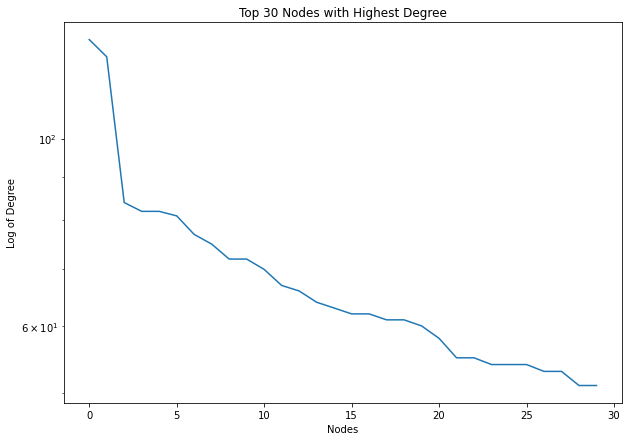

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [8]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

autothrall
hells_unicorn


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                #G[genre1][genre2]['concepts'] = G[genre1][genre2]['concepts'].union(B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G[genre1][genre2]['users'].add(user)
            else:
                G.add_edge(genre1, genre2, weight = 1)
                #G.add_edge(genre1, genre2, weight = 1, concepts = B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

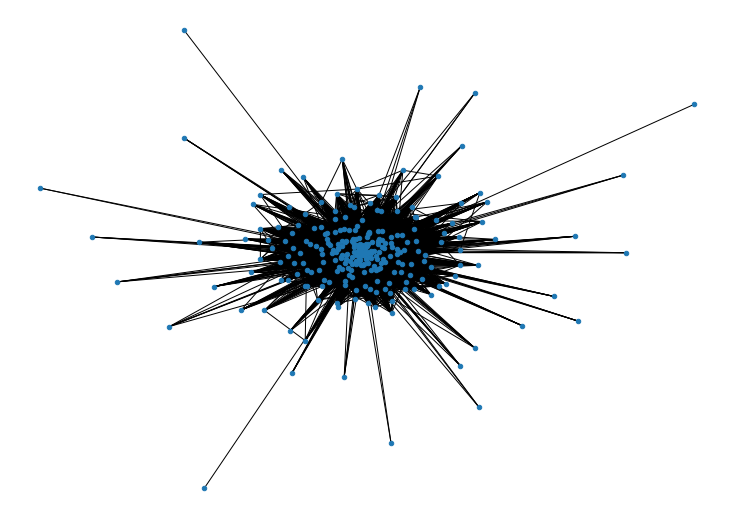

In [11]:
nx.draw(G, node_size = 20)

In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [14]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [15]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [16]:
G3 = G.copy()

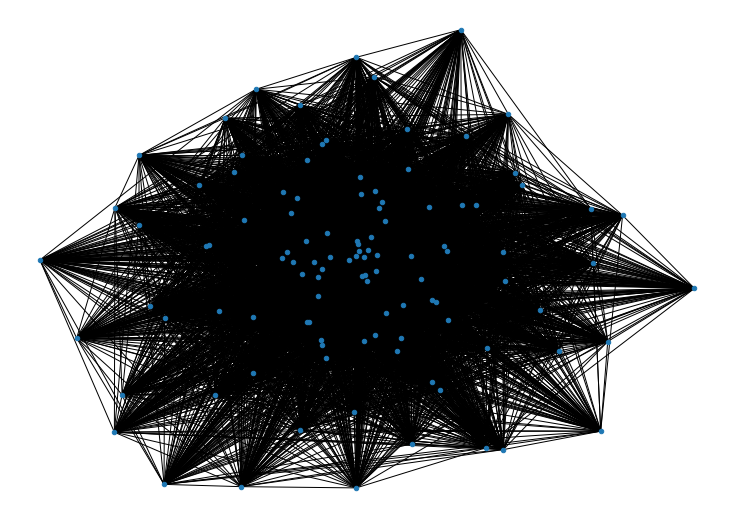

In [17]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
nx.draw(Core, node_size = 20)

In [18]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

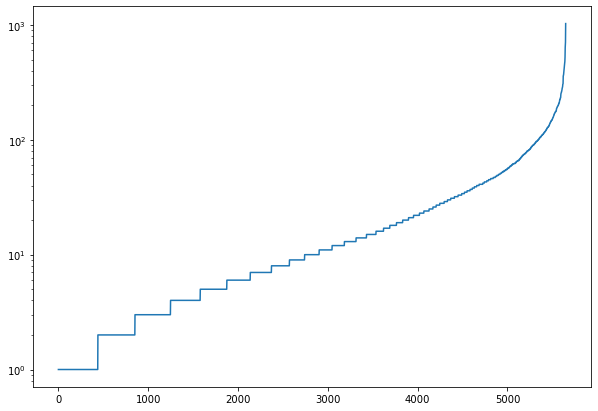

In [19]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))

In [20]:
tmp = sorted(list(nx.get_edge_attributes(Core,'weight').values()))
for i in range(len(tmp)):
    if (tmp[i] == 33):
        print(i)
        break

4450


(array([2136.,  911.,  643.,  330.,  275.,  195.,  167.,  132.,  128.,
          83.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

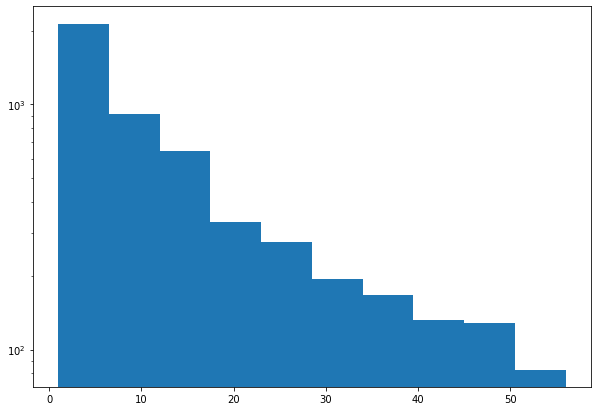

In [21]:
plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

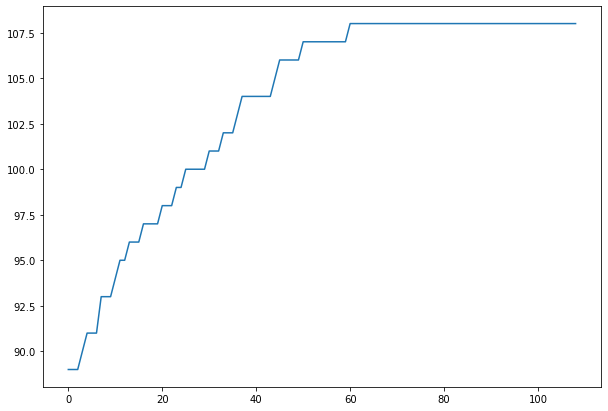

In [22]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.plot([x[0] for x in tmp])
plt.show()

In [23]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [24]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [25]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

'''plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()'''

"plt.title('Modularity against Weight Threshold')\nplt.ylabel('Modularity')\nmods = [plotThreshold(Core.copy(), i) for i in range(15,25)]\nplt.plot(mods)\nplt.show()"

In [26]:
#print(list(enumerate(mods)))

In [27]:
'''#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()
CoreNew = Core
'''

"#Use modularity and Inter-Intra edges to determine weight threshold\n#Use value of 20 (remove any edge below 20)\nCoreNew = nx.Graph(Core)\nedgeThres = 20\nfor u,v in Core.edges():\n    if Core[u][v]['weight'] < edgeThres:\n        CoreNew.remove_edge(u,v)\nprint(list(nx.isolates(CoreNew)))\nCoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))\nCoreNew.number_of_nodes(),CoreNew.number_of_edges()\nCoreNew = Core\n"

In [28]:
#H = G.copy()
H = Core.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 5886 5649
1 5886 3959
1 5886 3959
3 2370 2370


In [29]:
partitions = [cc for cc in nx.connected_components(H)]

In [30]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [31]:
[len(cc) for cc in partitions]

[12, 49, 48]

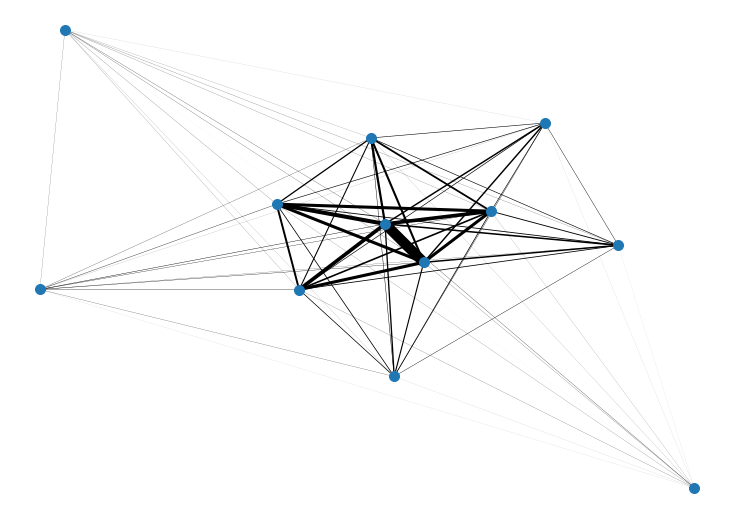

In [32]:
cluster = Core.subgraph(list(nx.connected_components(H))[0])
nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()

In [33]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{blackened thrash metal, black metal, death me...",12,103.515152,103.515152,1.000000,153.860547,0.073517
1,"{melodic black metal, atmospheric sludge metal...",49,21.895147,21.485544,0.981293,29.405465,0.065932
2,"{neoclassical heavy metal, alternative thrash ...",48,25.234534,24.227837,0.960106,54.810346,0.023615


In [34]:
clusters = []
inp = int(input('Enter Cluster ID to Keep: '))
clusters.append(G.subgraph(list(nx.connected_components(H))[inp]))

Enter Cluster ID to Keep:  0


In [35]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters.append(Core.subgraph(comp))

In [36]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  1 2


1 1176 1154
1 1176 801
1 1176 801
4 333 333
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{melodic black metal, pagan black metal, pagan...",21,23.403846,23.180952,0.990476,25.825420,0.127748
1,"{depressive black metal, shoegaze, atmospheric...",9,32.250000,32.250000,1.000000,29.780097,0.189402
2,"{atmospheric gothic metal, atmospheric doom me...",7,18.238095,18.238095,1.000000,27.030679,0.123386
3,"{stoner metal, ambient doom metal, experimenta...",12,31.333333,31.333333,1.000000,51.249932,0.084124


1 1128 1083
1 1128 905
1 1128 905
1 1128 582
1 1128 582
2 556 556
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{neoclassical heavy metal, alternative thrash ...",26,9.452769,8.929231,0.944615,11.975010,0.107626
1,"{melodic power metal, thrash metal, melodic de...",22,59.057018,58.290043,0.987013,102.213877,0.057809


103.51515151515152


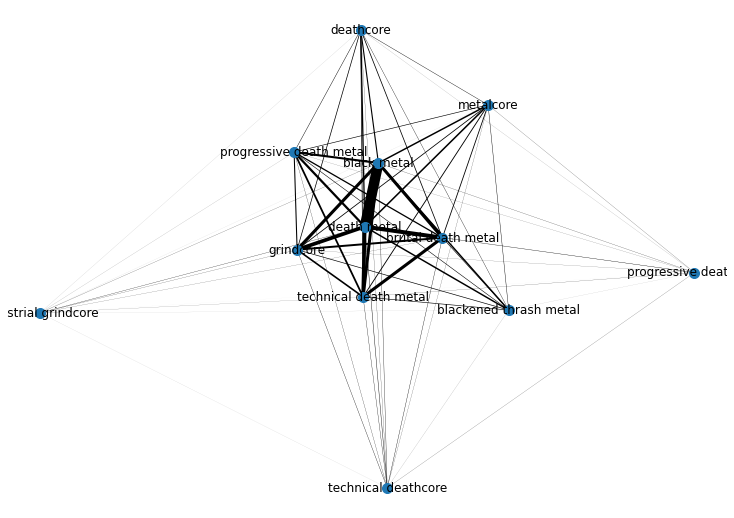

23.403846153846153


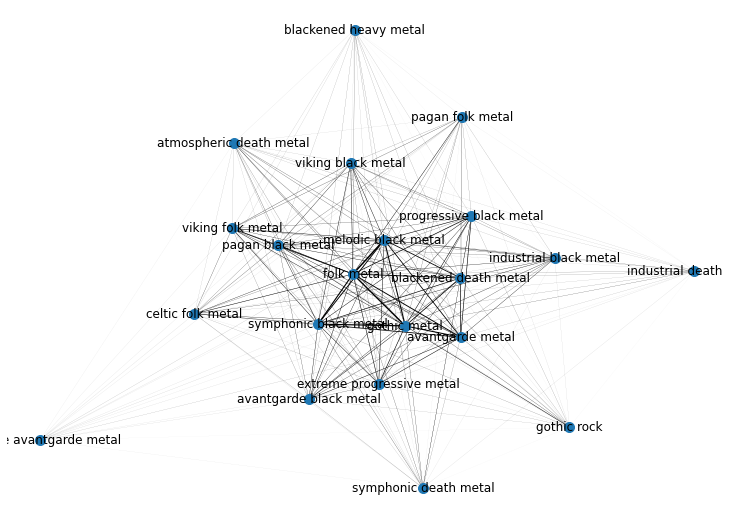

32.25


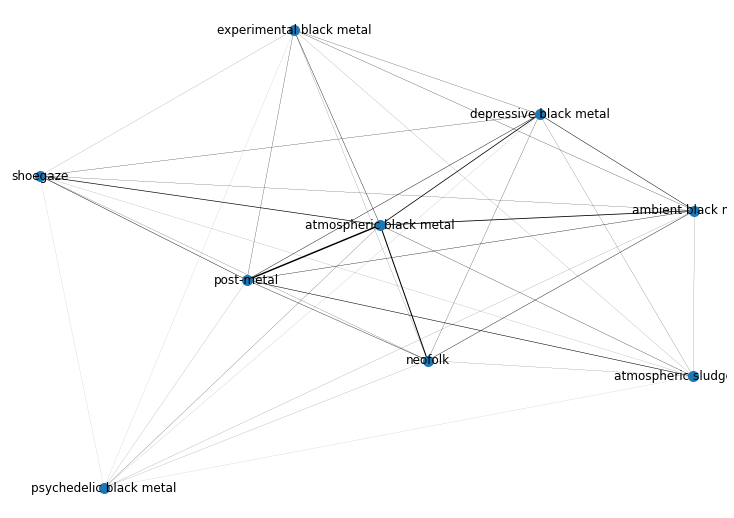

18.238095238095237


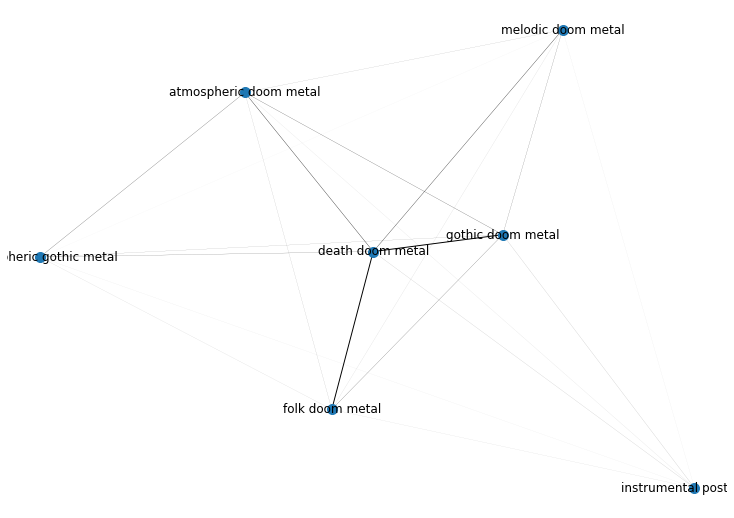

31.333333333333332


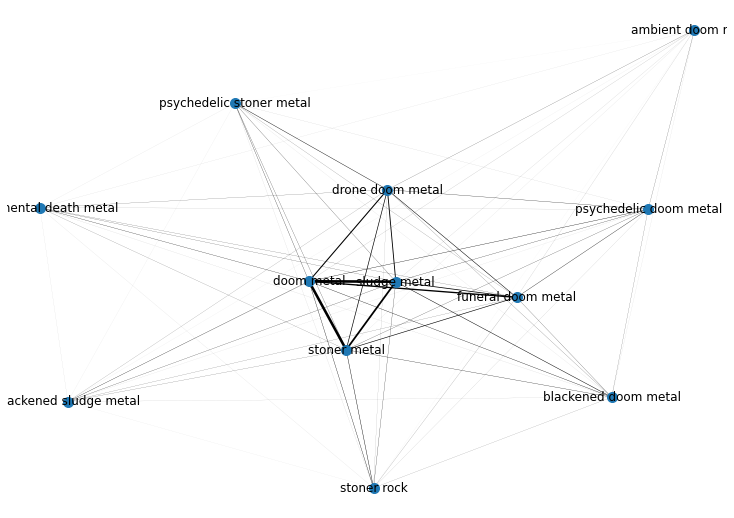

9.452768729641694


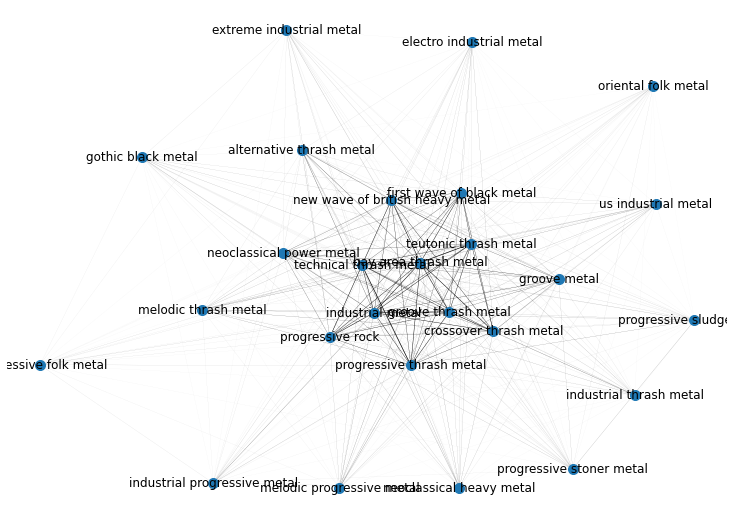

59.05701754385965


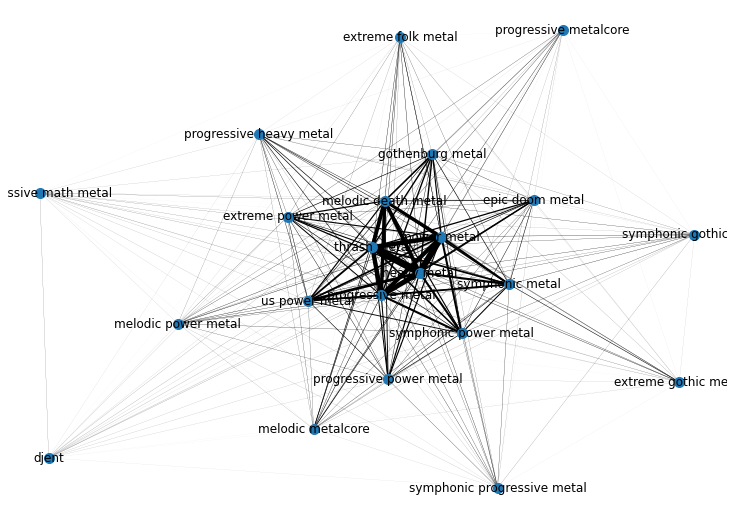

In [37]:
for cluster in clusters:
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()

In [38]:
G['extreme folk metal']['extreme gothic metal']

{'weight': 4}

In [39]:
'''x = 'folk doom metal'
w = sorted([(Core[x][u]['weight'],u) for u in list(Core[x])])
w'''

"x = 'folk doom metal'\nw = sorted([(Core[x][u]['weight'],u) for u in list(Core[x])])\nw"

In [40]:
'''cluster = clusters[3]
nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()'''

"cluster = clusters[3]\nnx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)\nplt.show()"

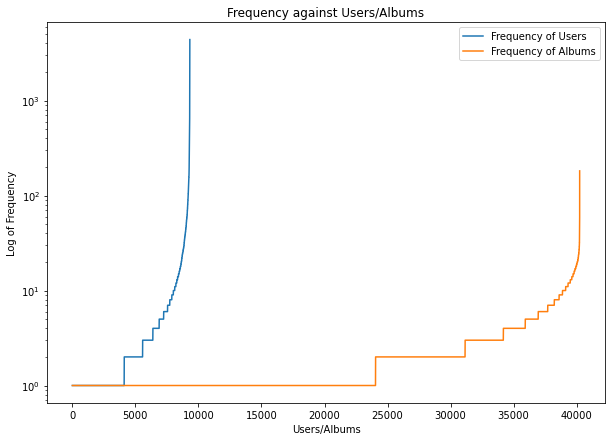

In [41]:
user_mp = clt.Counter(df['User'])
album_mp = clt.Counter(df['Release'])
#print(user_mp)
#print(album_mp)
plt.title('Frequency against Users/Albums')
plt.ylabel('Log of Frequency')
plt.xlabel('Users/Albums')
plt.semilogy(sorted(user_mp.values()), label = 'Frequency of Users')
plt.semilogy(sorted(album_mp.values()), label = 'Frequency of Albums')
plt.legend()
plt.show()

In [42]:
from concepts import Context

In [43]:
def genLattice(ind):
    cluster = clusters[ind]
    user_list = set()
    album_list = set()
    cxt = set()
    for u,v in cluster.edges():
        conc = cluster[u][v]['concepts']
        for album, user in conc:
            if user_mp[user] < 3 or album_mp[album[:-1]] < 10 or user in remove_users:
                continue
            user_list.add(user)
            album_list.add(album)
            cxt.add((album,user))
    user_list = list(user_list)
    album_list = list(album_list)
    print(ind, cluster.number_of_nodes(), len(user_list), len(album_list), len(cxt))
    context_df = pd.DataFrame()
    for user in user_list:
        arr = []
        for album in album_list:
            if (album,user) in cxt:
                arr.append('X')
            else:
                arr.append('')
        context_df[user] = arr
    context_df.index = album_list
    context_df.to_csv('fca.csv')
    c = Context.fromfile('fca.csv', frmat = 'csv')
    return l

In [44]:
def writeConcepts(ind):
    l = genLattice(ind)
    conc = sorted([(len(x),len(y)) for x,y in l], reverse = True)
    f = open('concepts_cluster'+str(ind)+'.txt','w')
    for x in conc:
        f.write(str(x))
        f.write('\n')
    f.close()
    return l

In [45]:
'''lats = []
for ind in range(len(clusters)):
    lats.append(writeConcepts(ind))'''

'lats = []\nfor ind in range(len(clusters)):\n    lats.append(writeConcepts(ind))'

In [46]:
'''l = genLattice(0)
x,y = l[1500]
x,y,len(l)'''

'l = genLattice(0)\nx,y = l[1500]\nx,y,len(l)'

In [47]:
#nx.write_gpickle(Core,'network_genres.p')

In [48]:
cluster_id = {}
for i,cluster in enumerate(clusters):
    for genre in cluster.nodes():
        cluster_id[genre] = i

In [49]:
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords 

def isNoun(tag):
    return tag == 'NN' or tag == 'NNS'
    #return tag[:2] == 'NN'

def isAdverb(tag):
    return tag == 'RB' or tag == 'RBR' or tag == 'RBS'
    #return tag[:2] == 'RB'


def isVerb(tag):
    return tag == 'VBN' or tag == 'VBD'
    #return tag[:2] == 'VB'


def extract_features(sent):
    sent = list(sent)
    sent += [('NULL','NULL'), ('NULL','NULL')]
    all_features = []
    for i in range(len(sent)-2):
        word1, tag1 = sent[i]
        word2, tag2 = sent[i+1]
        word3, tag3 = sent[i+2]
        word1 = word1.lower()
        word2 = word2.lower()
        word3 = word3.lower()
        if tag1 == 'JJ':
            if isNoun(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 2
                else:
                    all_features.append((word1, word2)) #pattern 1
                    
        elif isAdverb(tag1):
            if tag2 == 'JJ':
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                else:
                    all_features.append((word1, word2)) #pattern 3
            elif isAdverb(tag2):
                if isNoun(tag3):
                    all_features.append((word1, word2, word3)) #pattern 4
                elif tag3 == 'JJ':
                    all_features.append((word1, word2, word3)) #pattern 6
            elif isVerb(tag2):
                all_features.append((word1, word2)) #pattern 5
        
        elif isVerb(tag1):
            if isNoun(tag2):
                all_features.append((word1, word2)) #pattern 7
            elif isAdverb(tag2):
                all_features.append((word1, word2)) #pattern 8
                
                
                
    return all_features

In [58]:
t1 = time.time()
all_features = [{} for i in range(len(clusters))]

stop_words = set(stopwords.words('english')) 

for i,row in list(df.iterrows()):
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if i%5000 == 0:
        print(i,time.time()-t1)
    text = row['Text']
    sents = sent_tokenize(text)
    feature_list = []
    for sent in sents:
        tagged_sent = pos_tag([word for word in word_tokenize(sent) if word.isalnum() and len(word) > 1 and word not in stop_words])
        #print(tagged_sent)
        for phrase in extract_features(tagged_sent):
            feature = ' '.join(phrase)
            feature_list.append(feature)
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for phrase in feature_list:
            if phrase in all_features[clus]:
                all_features[clus][phrase] += 1
            else:
                all_features[clus][phrase] = 1

0 5.438486576080322
5000 152.75443387031555
20000 580.9782614707947
25000 766.3576383590698
30000 955.3706011772156
35000 1161.0637838840485
40000 1350.853809595108
45000 1524.6196269989014
50000 1699.8736975193024
55000 1870.8420000076294
60000 2053.52263379097
65000 2238.5609080791473
70000 2431.207632303238
75000 2614.9184324741364
85000 2995.129236936569


In [59]:
import pickle

pickle.dump(all_features,open('all_features_by_cluster.p','wb'))

In [61]:
print('Top 30 features for each cluster')
for i in range(len(clusters)):
    mp = {k: v for k, v in sorted(all_features[i].items(), key=lambda item: item[1], reverse = True)}
    print(list(mp.keys())[:30])
    print()

Top 30 features for each cluster
['black metal', 'brutal death metal', 'clean vocals', 'black metal band', 'old school', 'technical death metal', 'black metal bands', 'pretty much', 'originally written', 'old school death', 'melodic death metal', 'many bands', 'ever heard', 'whole album', 'double bass', 'little bit', 'deleted still', 'black metal album', 'full length', 'well done', 'written http', 'first time', 'black metal scene', 'entire album', 'first track', 'swedish death metal', 'long time', 'heavy metal', 'never heard', 'title track']

['black metal', 'clean vocals', 'female vocals', 'black metal band', 'originally written', 'whole album', 'harsh vocals', 'heavy metal', 'ever heard', 'acoustic guitars', 'pretty much', 'little bit', 'many bands', 'well done', 'entire album', 'first time', 'black metal bands', 'written http', 'gothic metal', 'melodic death metal', 'long time', 'deleted still', 'double bass', 'new album', 'previous albums', 'good album', 'never heard', 'black metal

In [ ]:
input()

In [ ]:
import nltk
import spacy
from nltk import bigrams, sent_tokenize
from spellchecker import SpellChecker

sp = spacy.load('en_core_web_sm')
spell = SpellChecker()

all_bigrams = [{} for i in range(len(clusters))]
all_stopwords = sp.Defaults.stop_words
tokenizer = nltk.RegexpTokenizer(r"\w+") # removes punctuation and special characters

def remove_word(word):
    return len(word) <= 2 or word in all_stopwords or not word.isalpha() or len(spell.unknown([word])) != 0
def isNaN(x):
    return x != x

a = time.time()
for i,row in df.iterrows():
    if i % 10000 == 0:
        print(i,time.time()-a)
    
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    sents = sent_tokenize(row['Text'])
    bigram_list = []
    for sent in sents:
        doc = tokenizer.tokenize(sent.lower())
        bigram_list = bigram_list + list(bigrams(doc))
        
    if not isNaN(row['Review_title']):
        doc = tokenizer.tokenize(row['Review_title'].lower())
        bigram_list = bigram_list + list(bigrams(doc))
    
    cleansed_blist = [bigram for bigram in bigram_list if not remove_word(bigram[0]) and not remove_word(bigram[1])]
    
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for bigram in cleansed_blist:
            if bigram in all_bigrams[clus]:
                all_bigrams[clus][bigram] += 1
            else:
                all_bigrams[clus][bigram] = 1

In [ ]:
def get_top_n(items,n = 100, plot_freq = False):
    cnt = clt.Counter(items)
    ret = sorted([(cnt[key],key) for key in cnt], reverse = True)
    if plot_freq:
        freq = [x for x,y in ret]
        plt.semilogy(freq[:50000])
    return ret[:n]

In [ ]:
get_top_n(all_bigrams[0], plot_freq = True)